### Data Preprocessing

In [ ]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 102.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import wfdb
import os
import numpy as np
import scipy.interpolate as interp
import copy
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
!pip install mamba-ssm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 7.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ninja-1.11.1.3-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (5.3 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  

In [ ]:
def read_records(data_dir):
  """
  Iterates through .dat files in data_dir, reads them using wfdb,
  and stores them in a dictionary.

  Args:
    data_dir: The directory containing the .dat files.

  Returns:
    A dictionary where keys are filenames (without extension) and
    values are wfdb.Record objects.
    Returns an empty dictionary if no .dat files are found or an error occurs.
  """
  records = {}
  for filename in os.listdir(data_dir):
    if filename.endswith(".dat"):
      record_id = filename[:-4]  # Remove the .dat extension
      try:
        record = wfdb.rdrecord(os.path.join(data_dir, record_id))
        records[record_id] = record
      except Exception as e:
        print(f"Error reading {filename}: {e}")
  return records



def preprocess_time_series(time_series, extrapolation = True, above_threshold = 210, below_threshold = 50, record_name="", print = False):
    """
    Preprocess time_series such as fetal heart rate (FHR) data:
    1. Replace extreme values (>210 or <50) and NaNs with 0.
    2. Use cubic spline interpolation for missing (zero) values.

    Parameters:
        below_threshold:
        above_threshold:
        extrapolation:
        time_series:
        fhr (numpy array): The fetal heart rate time series.
        max_missing_duration (int): Maximum duration for interpolation in seconds.

    Returns:
        numpy array: The preprocessed FHR data.
        True if no valid data points to extrapolate, False otherwise.
    """

    # deep copy fhr
    time_series = copy.deepcopy(time_series)

    time = np.arange(len(time_series))

    # Identify missing values (NaNs)
    missing_mask = np.isnan(time_series)

    # Identify extreme values (above 210 or below 50)
    extreme_mask = (time_series > above_threshold) | (time_series < below_threshold)

    # Replace extreme values and NaNs with 0
    time_series[missing_mask | extreme_mask] = 0
    # Replace extreme values and NaNs with 0
    time_series[missing_mask | extreme_mask] = 0

    # Identify all zero values for interpolation
    zero_mask = time_series == 0

    # Find valid (nonzero) values
    valid_idx = np.where(time_series != 0)[0]

    if len(valid_idx) < 2:
        if print == True: print(f"Warning: {record_name}, Not enough valid data points for interpolation. Returning original signal.")
        return time_series, True

    interpolator = interp.CubicSpline(valid_idx, time_series[valid_idx], extrapolate = extrapolation)
    time_series[zero_mask] = interpolator(np.where(zero_mask)[0])

    return time_series, False

def create_pytorch_tensor(records,process = False):
    """
    Creates a PyTorch tensor from a dictionary of wfdb records.

    Args:
        process:
        records: A dictionary where keys are record names and values are wfdb.Record objects.

    Returns:
        tensor: A PyTorch tensor of shape (num_records, 2, max_signal_length)
        or None if input is invalid.

        invalid_records: invalid to interpolate records

    """

    records = dict(sorted(all_records.items())) # Labels are sorted by name.

    if not isinstance(records, dict):
        print("Error: Input must be a dictionary of wfdb records.")
        return None,None

    # Find maximum signal length for padding
    max_signal_length = 0
    for record in records.values():
      max_signal_length = max(max_signal_length, len(record.p_signal))

    num_records = len(records)
    tensor_data = []
    invalid_records = []
    flag_fhr = flag_uc = False

    for record_name, record in records.items():
        # Pad signals to max length
        fhr = record.p_signal[:,0]
        uc = record.p_signal[:,1]

        if len(fhr)!=len(uc):
            print("len(fhr)!=len(uc)")

        if process:
            fhr,flag_fhr = preprocess_time_series(fhr, extrapolation = False)
            uc,flag_uc = preprocess_time_series(uc,extrapolation = False, above_threshold = 100, below_threshold = 4, record_name=record_name)

        if flag_fhr | flag_uc:
            invalid_records.append(int(record_name))

        fhr_padded = np.pad(fhr, (max_signal_length-len(fhr),0), 'constant') # padding at the beginning
        uc_padded = np.pad(uc, (max_signal_length-len(uc),0), 'constant')

        # Stack and append to list
        record_tensor = np.stack([fhr_padded, uc_padded], axis=0)
        tensor_data.append(record_tensor)

    # Convert the list of numpy arrays to a single numpy array
    tensor_data = np.array(tensor_data)
    # Convert to PyTorch tensor
    tensor = torch.tensor(tensor_data, dtype=torch.float32)

    return tensor, invalid_records

def filter_noisy_tensor(pytorch_tensor_processed,labels,invalid_records_names):
    """
    filters the noisy fhr,uc by locating interpolation hallucinations (fhr values below 50 or above 210 after interpolation)

    Returns: returns denoised data, and a equal in length corresponding labels tensor

    """

    # turn invalid record names into indices (CTU data), transform 0 no np.nan to isolate interpolation hallucinations.
    invalid_records_indices = [index - 1001 if index<2000 else index-494-1001 for index in invalid_records_names] #CTU record names into serial index
    pytorch_tensor_processed[pytorch_tensor_processed==0] = np.nan
    pytorch_tensor_processed_valid_uc = np.delete(pytorch_tensor_processed, invalid_records_indices, axis=0)
    labels_uc = labels[~labels["sample"].isin(invalid_records_names)]

    # Remove outliers - fhr interpolated values below 50 or above 210
    mask_below_50 = (pytorch_tensor_processed_valid_uc[:,0,:]<=50).sum(axis=1)>0
    mask_above_210 = (pytorch_tensor_processed_valid_uc[:,0,:]>=210).sum(axis=1)>0
    combined_mask = mask_below_50 | mask_above_210
    labels_no_extreme_interpolated = labels_uc[~combined_mask.numpy()]
    pytorch_tensor_no_extreme_interpolated = pytorch_tensor_processed_valid_uc[~combined_mask]

    # Reindex labels by the new data shape
    labels_no_extreme_interpolated = labels_no_extreme_interpolated.copy() # Prevent pandas warning about slicing
    labels_no_extreme_interpolated.loc[:,"old_index"] = labels_no_extreme_interpolated.index
    labels_no_extreme_interpolated_reindex = labels_no_extreme_interpolated.reset_index(drop=True)

    return pytorch_tensor_no_extreme_interpolated, labels_no_extreme_interpolated_reindex

def nanstd(o, dim, keepdim=False):
    """
    calculate std ingoring Nans

      Args:
          o: ovserved time series
          dim: dimension to calculate std
          keepdim: unsqueeze to keep dimension

    Return:
          std of the time series

    """

    result = torch.sqrt(
                torch.nanmean(
                    torch.pow( torch.abs(o-torch.nanmean(o,dim=dim).unsqueeze(dim)),2),
                    dim=dim
                )
            )

    if keepdim:
        result = result.unsqueeze(dim)

    return result

def normalize_ignor_nans(tensor, dim=1, keepdim=False):
    """
    Normalize the input tensor along the specified dimension while ignoring NaNs.

    Args:
        tensor (torch.Tensor): The input tensor to be normalized.
        dim (int): The dimension along which to perform normalization.
        keepdim (bool): Whether to keep the dimensions of the input tensor.

    Returns:
        torch.Tensor: The normalized tensor.

    """

    tensor_reshaped = tensor.view(-1, 21620)

    mean = torch.nanmean(tensor_reshaped, dim=1, keepdim=True)
    std = nanstd(tensor_reshaped, dim=1, keepdim=True)

    t_normalized = (tensor_reshaped - mean) / std
    print(t_normalized.shape)
    t_normalized= t_normalized.view(230,2,21620)

    return t_normalized

In [ ]:
labels_path = "/content/drive/MyDrive/Msc/Other Projects/RAJA/labels.csv"
data_dir = "/content/drive/MyDrive/Msc/Other Projects/RAJA/ctu-chb-intrapartum-cardiotocography-database-1.0.0"

all_records = read_records(data_dir)
labels = pd.read_csv(labels_path)

In [ ]:
t, _ = create_pytorch_tensor(all_records)

t_proc, invalid_records = create_pytorch_tensor(all_records, process= True)
print("t_proc.shape", t_proc.shape, "labels.shape", labels.shape,"invalid_records:", invalid_records)

t_filter, l_filter = filter_noisy_tensor(t_proc,labels,invalid_records)

print(t_filter.shape, "\n", l_filter.head())

t_normal = normalize_ignor_nans(t_filter)

print(t_normal.shape)

t_proc.shape torch.Size([552, 2, 21620]) labels.shape (552, 2) invalid_records: [1104, 1119, 1149]
torch.Size([230, 2, 21620]) 
    sample  label  old_index
0    1001      1          0
1    1004      0          3
2    1005      0          4
3    1017      1         16
4    1020      0         19
torch.Size([460, 21620])
torch.Size([230, 2, 21620])


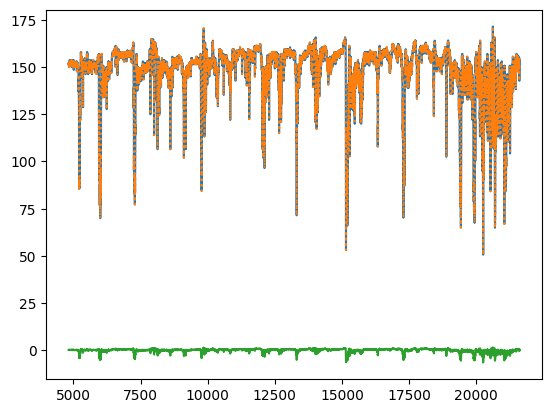

In [ ]:
# Sanity check:

plt.plot(t_proc[19,0,:]) # Old index
plt.plot(t_filter[4,0,:], linestyle='dotted') # New index
plt.plot(t_normal[4,0,:]) # New index normalized

### Models

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from mamba_ssm import Mamba

In [ ]:
class FHRDataset(Dataset):
    def __init__(self, data_tensor, labels_tensor):
        self.data = data_tensor  # Shape: [552, 2, 21620]
        self.labels = labels_tensor

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [ ]:
t_normal[:-1].shape

torch.Size([229, 2, 21620])

#### Next token prediction pretraining

In [ ]:
# Weighted Loss instead of full masking
def weighted_mse_loss(pred, target, weight=0.1):
    mask = (target.abs() > 1e-5).float()
    loss = ((pred - target) ** 2) * mask + ((pred - target) ** 2) * (1 - mask) * weight
    return loss.mean()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MambaNextToken(nn.Module):
    def __init__(self, d_model=2, d_state=16, d_conv=4, expand=2):
        super().__init__()
        self.mamba = Mamba(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand
        )
        self.proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        x = x.transpose(1, 2)  # (batch, d_model, seq_len) → (batch, seq_len, d_model)
        x = self.mamba(x)
        x = self.proj(x)
        x = x.transpose(1, 2)
        return x

X = torch.nan_to_num(t_normal[:,:,:-1].to(device))
Y = torch.nan_to_num(t_normal[:,:,1:].to(device))

print("X", X.shape, "Y", Y.shape)

dataset = TensorDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize Model, Loss & Optimizer
model = MambaNextToken().to(device)
criterion = nn.MSELoss()
optimizer_next_token = optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer_next_token, step_size=15, gamma=0.5)

# Init model
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)  # Xavier initialization for Linear layers
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Training Loop
epochs = 45
for epoch in range(epochs):
    total_loss = 0
    for x_batch, y_batch in dataloader:

        mask = (y_batch.abs() > 1e-5).float()  # Mask where target is NOT zero

        optimizer_next_token.zero_grad()
        y_pred = model(x_batch)

        loss = weighted_mse_loss(y_pred, y_batch, mask)  # Apply masked loss
        loss.backward()
        optimizer_next_token.step()

        total_loss += loss.item()


    scheduler.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.6f}")

# Save Pretrained Weights
torch.save(model.state_dict(), "mamba_pretrained.pth")
print("✅ Pretraining Complete!")

X torch.Size([230, 2, 21619]) Y torch.Size([230, 2, 21619])
Epoch [1/45], Loss: 0.732265
Epoch [2/45], Loss: 0.732572
Epoch [3/45], Loss: 0.729622
Epoch [4/45], Loss: 0.714615
Epoch [5/45], Loss: 0.710071
Epoch [6/45], Loss: 0.708182
Epoch [7/45], Loss: 0.690483
Epoch [8/45], Loss: 0.666955
Epoch [9/45], Loss: 0.649730
Epoch [10/45], Loss: 0.638807
Epoch [11/45], Loss: 0.618027
Epoch [12/45], Loss: 0.596149
Epoch [13/45], Loss: 0.578471
Epoch [14/45], Loss: 0.567323
Epoch [15/45], Loss: 0.540126
Epoch [16/45], Loss: 0.528029
Epoch [17/45], Loss: 0.529012
Epoch [18/45], Loss: 0.512279
Epoch [19/45], Loss: 0.506897
Epoch [20/45], Loss: 0.497298
Epoch [21/45], Loss: 0.492743
Epoch [22/45], Loss: 0.480961
Epoch [23/45], Loss: 0.469540
Epoch [24/45], Loss: 0.464720
Epoch [25/45], Loss: 0.458076
Epoch [26/45], Loss: 0.454161
Epoch [27/45], Loss: 0.447784
Epoch [28/45], Loss: 0.444679
Epoch [29/45], Loss: 0.428592
Epoch [30/45], Loss: 0.428040
Epoch [31/45], Loss: 0.416334
Epoch [32/45], Loss

#### Mamba classifier

In [ ]:
class MambaBinaryClassifier(nn.Module):
    def __init__(self, d_model=2, d_state=16, d_conv=4, expand=2, dropout_rate=0.3, linear_input_dim = 21620):
        super().__init__()
        self.mamba = Mamba(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand
        )

        # Final classifier
        self.proj = nn.Linear(linear_input_dim, 512)  # Reduce dimensions first
        self.dropout = nn.Dropout(p=dropout_rate)  # Dropout layer
        self.classifier = nn.Linear(512, 1)

    def forward(self, x):
        x = x.transpose(1, 2)  # (batch, d_model, seq_len) → (batch, seq_len, d_model)
        x = self.mamba(x)  # (batch, seq_len, d_model)

        x = x[:, :, 0]  # Select the first channel (batch, seq_len)

        x = self.proj(x)
        x = self.dropout(x)  # Apply dropout before classification
        x = self.classifier(x)
        return torch.sigmoid(x)


In [ ]:
# Model parameters
d_model = 2
d_state = 16
d_conv = 8
expand = 4

# Learning parameteres

start_lr = 0.001
scheduler_step_size = 15
gamma = 0.5

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import roc_auc_score, confusion_matrix

# Load pre-trained model
mamba_pretrained = MambaNextToken()
mamba_pretrained.load_state_dict(torch.load("mamba_pretrained.pth"))


# Dataset and DataLoader
l_filter_tensor = torch.tensor(l_filter["label"].values, dtype=torch.float32)
dataset = FHRDataset(torch.nan_to_num(t_normal), l_filter_tensor)

# Split dataset into train and test
train_size = int(0.8 * len(dataset))  # 80% train, 20% test
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = MambaBinaryClassifier(d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand, dropout_rate=0).to(device)

# Load pre-trained weights for 'mamba' module
pretrained_state_dict = mamba_pretrained.mamba.state_dict()
modified_state_dict = {k[6:]: v for k, v in pretrained_state_dict.items() if k.startswith('mamba.')}
model.mamba.load_state_dict(modified_state_dict, strict=False)

# Optimizer, loss, scheduler
optimizer = optim.Adam(model.parameters(), lr=start_lr)
weights = torch.tensor([1.0, 2.0])  # Increase weight for the minority class (class 1)
criterion = nn.BCEWithLogitsLoss(pos_weight=weights[1]).to(device)
scheduler = StepLR(optimizer, step_size=scheduler_step_size, gamma=gamma)

def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, scheduler, num_epochs=40):
    writer = SummaryWriter()

    """Train and evaluate function"""
    model.train()

    # Freeze 'mamba' layer initially
    for param in model.mamba.parameters():
        param.requires_grad = False

    for epoch in range(num_epochs):
        total_train_loss, total_train_accuracy = 0, 0
        total_test_loss, total_test_accuracy = 0, 0
        all_train_labels, all_train_preds = [], []
        all_test_labels, all_test_preds = [], []

        if epoch == 6:
            for param in model.mamba.parameters():
                param.requires_grad = True

        # Training
        model.train()
        for inputs, labels in train_loader:
            if torch.isnan(inputs).any() or torch.isinf(inputs).any():
                print("Warning: Input contains NaNs or Infs!")
                continue

            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            accuracy = (outputs.round() == labels.unsqueeze(1).float()).float().mean()
            total_train_accuracy += accuracy.item()

            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(outputs.cpu().detach().numpy())

        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_acc = total_train_accuracy / len(train_loader)

        # Compute sensitivity, specificity, AUC for training
        train_preds = [1 if x >= 0.5 else 0 for x in all_train_preds]
        cm = confusion_matrix(all_train_labels, train_preds)
        sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
        specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
        auc = roc_auc_score(all_train_labels, all_train_preds)
        precision = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0


        writer.add_scalar("Loss/train", avg_train_loss, epoch)
        writer.add_scalar("Accuracy/train", avg_train_acc, epoch)
        writer.add_scalar("Sensitivity/train", sensitivity, epoch)
        writer.add_scalar("Specificity/train", specificity, epoch)
        writer.add_scalar("AUC/train", auc, epoch)
        writer.add_scalar("Precision/train", precision, epoch)

        # Testing
        model.eval()
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.unsqueeze(1).float())
                total_test_loss += loss.item()
                accuracy = (outputs.round() == labels.unsqueeze(1).float()).float().mean()
                total_test_accuracy += accuracy.item()


                all_test_labels.extend(labels.cpu().numpy())
                all_test_preds.extend(outputs.cpu().detach().numpy())

        avg_test_loss = total_test_loss / len(test_loader)
        avg_test_acc = total_test_accuracy / len(test_loader)
               # Compute sensitivity, specificity, AUC for testing
        # Check if cm has the expected shape
        if len(all_test_labels) > 0 and len(np.unique(all_test_labels)) > 1:
            test_preds = [1 if x >= 0.5 else 0 for x in all_test_preds]
            cm = confusion_matrix(all_test_labels, test_preds)

            # Calculate sensitivity and specificity only if cm has the correct shape
            sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
            specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
            precision = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0
            auc = roc_auc_score(all_test_labels, all_test_preds)
        else:
            print("len(all_test_labels)", len(all_test_labels), "len(np.unique(all_test_labels)",len(np.unique(all_test_labels)))
            sensitivity, specificity, auc = 0, 0, 0  # Set metrics to 0 if cm is invalid

        writer.add_scalar("Loss/test", avg_test_loss, epoch)
        writer.add_scalar("Accuracy/test", avg_test_acc, epoch)
        writer.add_scalar("Sensitivity/test", sensitivity, epoch)
        writer.add_scalar("Specificity/test", specificity, epoch)
        writer.add_scalar("AUC/test", auc, epoch)
        writer.add_scalar("Precision/train", precision, epoch)


        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f} | Test Loss: {avg_test_loss:.4f}, Test Acc: {avg_test_acc:.4f}")
        scheduler.step()
        writer.add_scalar("Learning Rate", optimizer.param_groups[0]['lr'], epoch)

    writer.flush()
    return writer

# Run training and evaluation
writer = train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, scheduler)

Epoch 1: Train Loss: 0.9682, Train Acc: 0.5729 | Test Loss: 0.9736, Test Acc: 0.4762
Epoch 2: Train Loss: 0.8274, Train Acc: 0.7812 | Test Loss: 0.9656, Test Acc: 0.5238
Epoch 3: Train Loss: 0.7884, Train Acc: 0.8385 | Test Loss: 0.9925, Test Acc: 0.5119
Epoch 4: Train Loss: 0.7527, Train Acc: 0.8958 | Test Loss: 0.9937, Test Acc: 0.5000
Epoch 5: Train Loss: 0.7365, Train Acc: 0.9115 | Test Loss: 1.0054, Test Acc: 0.4762
Epoch 6: Train Loss: 0.7215, Train Acc: 0.9375 | Test Loss: 1.0066, Test Acc: 0.5030
Epoch 7: Train Loss: 0.7193, Train Acc: 0.9375 | Test Loss: 1.0262, Test Acc: 0.4583
Epoch 8: Train Loss: 0.7284, Train Acc: 0.9219 | Test Loss: 1.0242, Test Acc: 0.4494
Epoch 9: Train Loss: 0.7205, Train Acc: 0.9271 | Test Loss: 1.0239, Test Acc: 0.4345
Epoch 10: Train Loss: 0.7151, Train Acc: 0.9427 | Test Loss: 1.0171, Test Acc: 0.4583
Epoch 11: Train Loss: 0.7159, Train Acc: 0.9375 | Test Loss: 1.0449, Test Acc: 0.4315
Epoch 12: Train Loss: 0.7098, Train Acc: 0.9479 | Test Loss: 1.

In [ ]:
writer.get_logdir()

'runs/Mar15_17-22-13_1dc844115610'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator


def plot_accuracy_from_tensorboard(log_dir):

    # Load TensorBoard events
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()

    # Extract accuracy values
    train_accuracy = event_acc.Scalars("Accuracy/train")
    test_accuracy = event_acc.Scalars("Accuracy/test")

    # Convert to lists
    epochs = [x.step for x in train_accuracy]
    train_acc_values = [x.value for x in train_accuracy]
    test_acc_values = [x.value for x in test_accuracy]

    # Plot accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_acc_values, label="Train Accuracy", marker="o")
    plt.plot(epochs, test_acc_values, label="Test Accuracy", marker="s")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Test Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

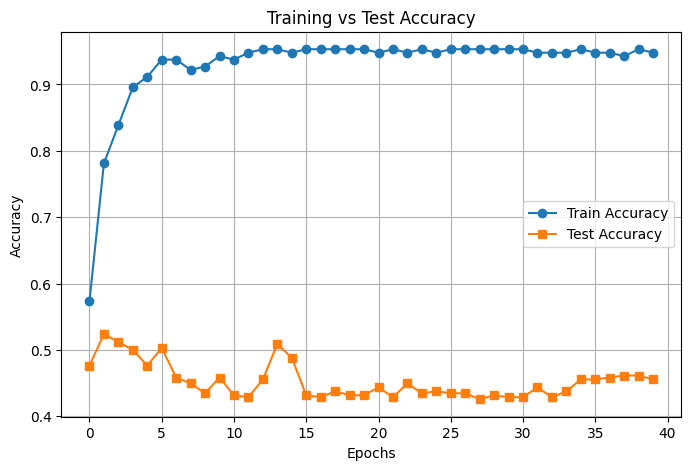

In [ ]:
plot_accuracy_from_tensorboard(writer.get_logdir())

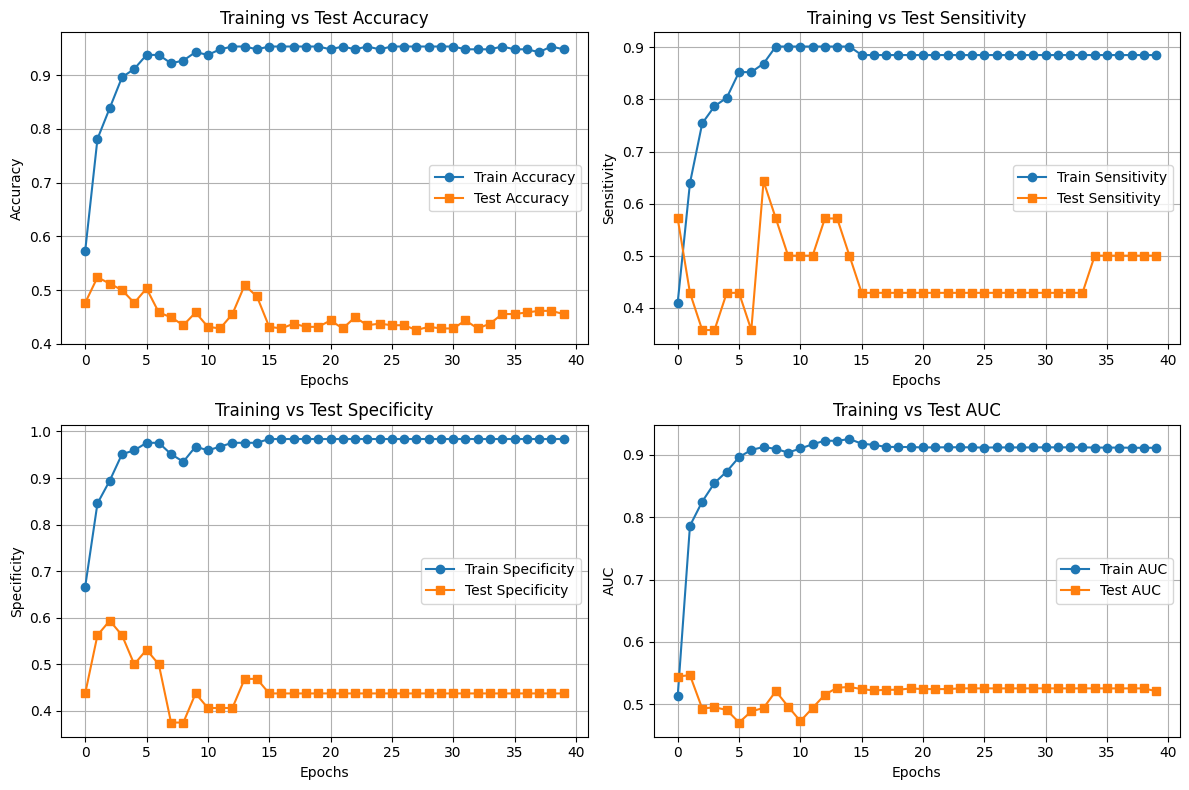

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def plot_metrics_from_tensorboard(log_dir):
    # Load TensorBoard events
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()

    # Extract metrics
    train_accuracy = event_acc.Scalars("Accuracy/train")
    test_accuracy = event_acc.Scalars("Accuracy/test")
    train_sensitivity = event_acc.Scalars("Sensitivity/train")
    test_sensitivity = event_acc.Scalars("Sensitivity/test")
    train_specificity = event_acc.Scalars("Specificity/train")
    test_specificity = event_acc.Scalars("Specificity/test")
    train_auc = event_acc.Scalars("AUC/train")
    test_auc = event_acc.Scalars("AUC/test")

    # Convert to lists
    epochs = [x.step for x in train_accuracy]
    train_acc_values = [x.value for x in train_accuracy]
    test_acc_values = [x.value for x in test_accuracy]

    train_sens_values = [x.value for x in train_sensitivity]
    test_sens_values = [x.value for x in test_sensitivity]

    train_spec_values = [x.value for x in train_specificity]
    test_spec_values = [x.value for x in test_specificity]

    train_auc_values = [x.value for x in train_auc]
    test_auc_values = [x.value for x in test_auc]

    # Plot Accuracy
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_acc_values, label="Train Accuracy", marker="o")
    plt.plot(epochs, test_acc_values, label="Test Accuracy", marker="s")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Test Accuracy")
    plt.legend()
    plt.grid()

    # Plot Sensitivity
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_sens_values, label="Train Sensitivity", marker="o")
    plt.plot(epochs, test_sens_values, label="Test Sensitivity", marker="s")
    plt.xlabel("Epochs")
    plt.ylabel("Sensitivity")
    plt.title("Training vs Test Sensitivity")
    plt.legend()
    plt.grid()

    # Plot Specificity
    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_spec_values, label="Train Specificity", marker="o")
    plt.plot(epochs, test_spec_values, label="Test Specificity", marker="s")
    plt.xlabel("Epochs")
    plt.ylabel("Specificity")
    plt.title("Training vs Test Specificity")
    plt.legend()
    plt.grid()

    # Plot AUC
    plt.subplot(2, 2, 4)
    plt.plot(epochs, train_auc_values, label="Train AUC", marker="o")
    plt.plot(epochs, test_auc_values, label="Test AUC", marker="s")
    plt.xlabel("Epochs")
    plt.ylabel("AUC")
    plt.title("Training vs Test AUC")
    plt.legend()
    plt.grid()

    # Show all plots
    plt.tight_layout()
    plt.show()

# Call the function with the log directory
plot_metrics_from_tensorboard(writer.get_logdir())


#### Dropout

In [ ]:
# Initialize model, with dropout
model = MambaBinaryClassifier(d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand, dropout_rate=0.3).to(device)

# Load pre-trained weights for 'mamba' module
pretrained_state_dict = mamba_pretrained.mamba.state_dict()
modified_state_dict = {k[6:]: v for k, v in pretrained_state_dict.items() if k.startswith('mamba.')}
model.mamba.load_state_dict(modified_state_dict, strict=False)

# Optimizer, loss, scheduler
optimizer = optim.Adam(model.parameters(), lr=start_lr)
criterion = nn.BCEWithLogitsLoss(pos_weight=weights[1]).to(device)
scheduler = StepLR(optimizer, step_size=scheduler_step_size, gamma=gamma)

writer = train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, scheduler)

Epoch 1: Train Loss: 0.9472, Train Acc: 0.6198 | Test Loss: 0.9351, Test Acc: 0.6726
Epoch 2: Train Loss: 0.8706, Train Acc: 0.7240 | Test Loss: 0.9557, Test Acc: 0.6310
Epoch 3: Train Loss: 0.8241, Train Acc: 0.8073 | Test Loss: 0.9807, Test Acc: 0.5595
Epoch 4: Train Loss: 0.7910, Train Acc: 0.8646 | Test Loss: 0.9994, Test Acc: 0.4940
Epoch 5: Train Loss: 0.7525, Train Acc: 0.9062 | Test Loss: 1.0073, Test Acc: 0.4792
Epoch 6: Train Loss: 0.7404, Train Acc: 0.9219 | Test Loss: 1.0027, Test Acc: 0.4762
Epoch 7: Train Loss: 0.7265, Train Acc: 0.9323 | Test Loss: 0.9805, Test Acc: 0.5298
Epoch 8: Train Loss: 0.7228, Train Acc: 0.9323 | Test Loss: 0.9876, Test Acc: 0.5417
Epoch 9: Train Loss: 0.7180, Train Acc: 0.9375 | Test Loss: 0.9917, Test Acc: 0.5387
Epoch 10: Train Loss: 0.7140, Train Acc: 0.9427 | Test Loss: 0.9852, Test Acc: 0.5476
Epoch 11: Train Loss: 0.7136, Train Acc: 0.9427 | Test Loss: 0.9875, Test Acc: 0.5417
Epoch 12: Train Loss: 0.7171, Train Acc: 0.9375 | Test Loss: 0.

In [ ]:
writer.get_logdir()

'runs/Mar15_17-22-26_1dc844115610'

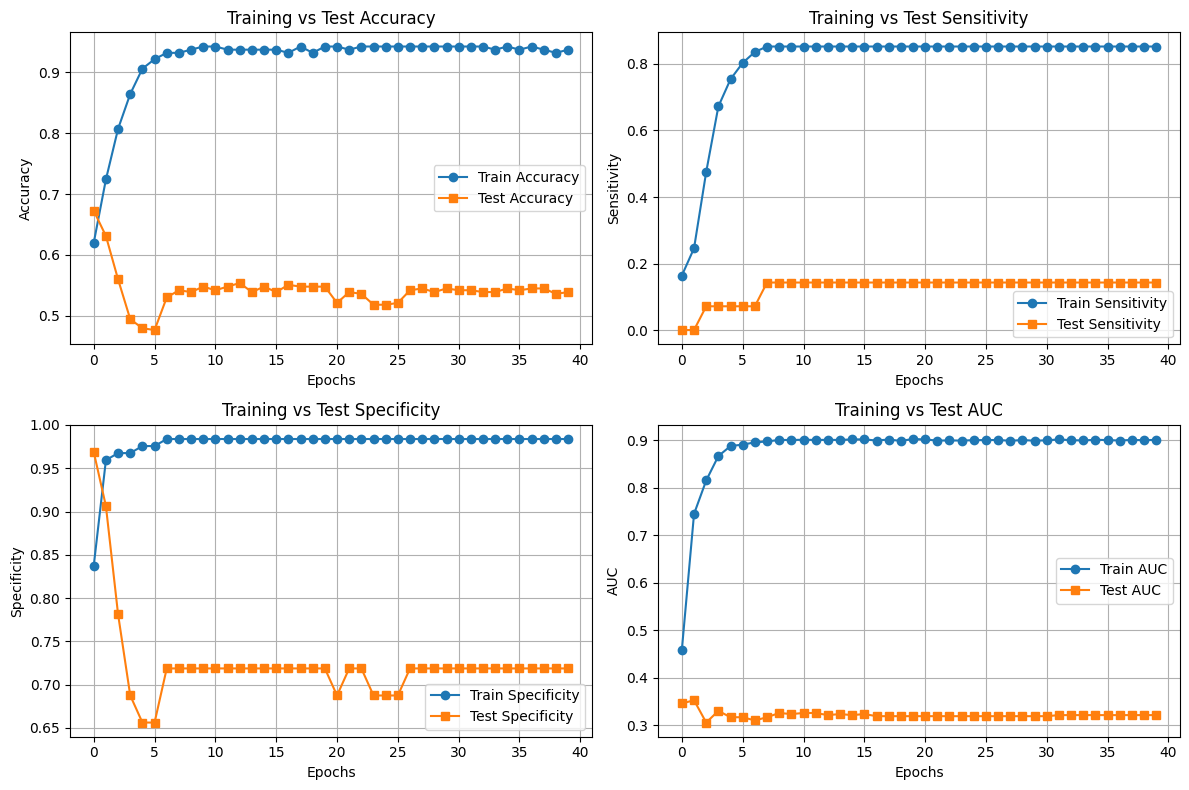

In [ ]:
plot_metrics_from_tensorboard(writer.get_logdir())

#### Data Augmentation

In [ ]:
import torch

def add_gaussian_noise(data, mean=0.0, std=0.01):
    """
    Adds Gaussian noise to a batch of data.

    Parameters:
        data (torch.Tensor): Input tensor of shape (batch, channels, seq_length)
        mean (float): Mean of Gaussian noise
        std (float): Standard deviation of Gaussian noise

    Returns:
        torch.Tensor: Noisy data
    """
    noise = torch.randn_like(data) * std + mean
    return data + noise

# Example usage
data_aug = t_normal.clone()
noisy_data = add_gaussian_noise(data_aug, std=0.02)

In [ ]:
def add_variable_gaussian_noise(data, mean=0.0, base_std=0.01, std_variation=0.005):
    """
    Adds Gaussian noise with a variable standard deviation across the sequence length.

    Parameters:
        data (torch.Tensor): Input tensor of shape (batch, channels, seq_length)
        mean (float): Mean of Gaussian noise
        base_std (float): Base standard deviation for the noise
        std_variation (float): How much std can vary across the sequence

    Returns:
        torch.Tensor: Noisy data
    """
    batch, channels, seq_length = data.shape

    # Generate random std values per sequence position (smooth transitions)
    std_values = base_std + torch.rand(batch, channels, seq_length) * std_variation

    # Generate Gaussian noise with varying std
    noise = torch.randn_like(data) * std_values + mean
    return data + noise

#### last hour data, liner interpolation, mean over 1 HZ mamba

data analysis was done in https://colab.research.google.com/drive/1eJ0DksxS18Dz8noNaBb3BoBcp3dxfZgM.

In [ ]:
labels_2m_gaps = pd.read_csv("/content/labels_no_2min_gaps.csv")
t_lasthour_no2m_gaps_linearinterp_mean1hz = torch.load("/content/last_hour_no_2min_gaps_linear_interp_mean1hz_tensor.pt")

In [ ]:
class MambaNextToken(nn.Module):
    def __init__(self, d_model=2, d_state=16, d_conv=4, expand=2):
        super().__init__()
        self.mamba = Mamba(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand
        )
        self.proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        # print("1", torch.isnan(x).any())
        x = x.transpose(1, 2)  # (batch, d_model, seq_len) → (batch, seq_len, d_model)
        # print("2", torch.isnan(x).any())
        x = self.mamba(x)
        # print("3", torch.isnan(x).any())
        x = self.proj(x)
        # print("4", torch.isnan(x).any())
        x = x.transpose(1, 2)
        return x

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X = t_lasthour_no2m_gaps_linearinterp_mean1hz[:,:,:-1].to(device)
Y = t_lasthour_no2m_gaps_linearinterp_mean1hz[:,:,1:].to(device)

# Fill mean in X
dim_1_means = torch.nanmean(X[:, 0, :], dim=1, keepdim=True)
expanded_means = dim_1_means.expand(-1, X.shape[2])
X[:, 0, :] = torch.where(torch.isnan(X[:, 0, :]), expanded_means, X[:, 0, :])

eps = 1e-6  # Small constant to prevent NaNs
X_std = torch.std(X, dim=2, keepdim=True)
X_std = torch.where(X_std == 0, torch.tensor(eps, device=X.device), X_std)  # Replace zero stds
X_normalized = (X - torch.mean(X, dim=2, keepdim=True)) / X_std
Y_std = torch.std(Y, dim=2, keepdim=True)
Y_std = torch.where(Y_std == 0, torch.tensor(eps, device=Y.device), Y_std)
Y_normalized = (Y - torch.mean(Y, dim=2, keepdim=True)) / Y_std

dataset = TensorDataset(X_normalized, Y_normalized)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize Model, Loss & Optimizer
model = MambaNextToken().to(device)
criterion = nn.MSELoss()
optimizer_next_token = optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer_next_token, step_size=15, gamma=0.5)

# Init model
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)  # Xavier initialization for Linear layers
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Training Loop
epochs = 45
for epoch in range(epochs):
    total_loss = 0
    for x_batch, y_batch in dataloader:

        optimizer_next_token.zero_grad()
        y_pred = model(x_batch)

        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer_next_token.step()

        total_loss += loss.item()


    scheduler.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.6f}")

# Save Pretrained Weights
torch.save(model.state_dict(), "mamba_pretrained_t_lasthour_no2m_gaps_linearinterp_mean1hz.pth")
print("✅ Pretraining Complete!")

Epoch [1/45], Loss: nan
Epoch [2/45], Loss: nan
Epoch [3/45], Loss: nan
Epoch [4/45], Loss: nan
Epoch [5/45], Loss: nan
Epoch [6/45], Loss: nan
Epoch [7/45], Loss: nan
Epoch [8/45], Loss: nan
Epoch [9/45], Loss: nan
Epoch [10/45], Loss: nan
Epoch [11/45], Loss: nan
Epoch [12/45], Loss: nan
Epoch [13/45], Loss: nan
Epoch [14/45], Loss: nan
Epoch [15/45], Loss: nan
Epoch [16/45], Loss: nan
Epoch [17/45], Loss: nan
Epoch [18/45], Loss: nan
Epoch [19/45], Loss: nan
Epoch [20/45], Loss: nan
Epoch [21/45], Loss: nan
Epoch [22/45], Loss: nan
Epoch [23/45], Loss: nan
Epoch [24/45], Loss: nan
Epoch [25/45], Loss: nan
Epoch [26/45], Loss: nan
Epoch [27/45], Loss: nan
Epoch [28/45], Loss: nan
Epoch [29/45], Loss: nan
Epoch [30/45], Loss: nan
Epoch [31/45], Loss: nan
Epoch [32/45], Loss: nan
Epoch [33/45], Loss: nan
Epoch [34/45], Loss: nan
Epoch [35/45], Loss: nan
Epoch [36/45], Loss: nan
Epoch [37/45], Loss: nan
Epoch [38/45], Loss: nan
Epoch [39/45], Loss: nan
Epoch [40/45], Loss: nan
Epoch [41

In [ ]:
labels_2m_gaps

,sample-id,label
0,1258,1
1,1301,0
2,1203,0
3,1068,0
4,1490,1
...,...,...
321,1197,1
322,1385,0
323,1065,1
324,1229,1


In [ ]:

# Fill mean in X
dim_1_means = torch.nanmean(t_lasthour_no2m_gaps_linearinterp_mean1hz[:, 0, :], dim=1, keepdim=True)
expanded_means = dim_1_means.expand(-1, t_lasthour_no2m_gaps_linearinterp_mean1hz.shape[2])
t_lasthour_no2m_gaps_linearinterp_mean1hz[:, 0, :] = torch.where(torch.isnan(t_lasthour_no2m_gaps_linearinterp_mean1hz[:, 0, :]), expanded_means, t_lasthour_no2m_gaps_linearinterp_mean1hz[:, 0, :])

eps = 1e-6  # Small constant to prevent NaNs
t_lasthour_no2m_gaps_linearinterp_mean1hz_std = torch.std(t_lasthour_no2m_gaps_linearinterp_mean1hz, dim=2, keepdim=True)
t_lasthour_no2m_gaps_linearinterp_mean1hz_std = torch.where(t_lasthour_no2m_gaps_linearinterp_mean1hz_std == 0, torch.tensor(eps, device=t_lasthour_no2m_gaps_linearinterp_mean1hz.device), t_lasthour_no2m_gaps_linearinterp_mean1hz_std)  # Replace zero stds
t_lasthour_no2m_gaps_linearinterp_mean1hz_normalized = (t_lasthour_no2m_gaps_linearinterp_mean1hz - torch.mean(t_lasthour_no2m_gaps_linearinterp_mean1hz, dim=2, keepdim=True)) / t_lasthour_no2m_gaps_linearinterp_mean1hz_std

In [ ]:
# Dataset and DataLoader
labels_2m_gaps_tensor = torch.tensor(labels_2m_gaps["label"].values, dtype=torch.float32)
dataset = FHRDataset(t_lasthour_no2m_gaps_linearinterp_mean1hz_normalized, labels_2m_gaps_tensor)

# Split dataset into train and test
train_size = int(0.8 * len(dataset))  # 80% train, 20% test
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [ ]:
# Initialize model, with dropout
model = MambaBinaryClassifier(d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand, dropout_rate=0.4, linear_input_dim = 3600).to(device)

# Load pre-trained weights for 'mamba' module
mamba_pretrained = MambaNextToken()
mamba_pretrained.load_state_dict(torch.load("/content/mamba_pretrained_t_lasthour_no2m_gaps_linearinterp_mean1hz.pth"))

pretrained_state_dict = mamba_pretrained.mamba.state_dict()
modified_state_dict = {k[6:]: v for k, v in pretrained_state_dict.items() if k.startswith('mamba.')}
model.mamba.load_state_dict(modified_state_dict, strict=False)

# Optimizer, loss, scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
criterion = nn.BCEWithLogitsLoss(pos_weight=weights[1]).to(device)
scheduler = StepLR(optimizer, step_size=scheduler_step_size, gamma=gamma)

writer = train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, scheduler)

Epoch 1: Train Loss: 0.9617, Train Acc: 0.5993 | Test Loss: 0.9582, Test Acc: 0.7000
Epoch 2: Train Loss: 0.9517, Train Acc: 0.6360 | Test Loss: 0.9547, Test Acc: 0.6375
Epoch 3: Train Loss: 0.9405, Train Acc: 0.6507 | Test Loss: 0.9460, Test Acc: 0.7250
Epoch 4: Train Loss: 0.9302, Train Acc: 0.7169 | Test Loss: 0.9524, Test Acc: 0.6875
Epoch 5: Train Loss: 0.9217, Train Acc: 0.7206 | Test Loss: 0.9437, Test Acc: 0.6875
Epoch 6: Train Loss: 0.9110, Train Acc: 0.7537 | Test Loss: 0.9296, Test Acc: 0.7750
Epoch 7: Train Loss: 0.9018, Train Acc: 0.7353 | Test Loss: 0.9233, Test Acc: 0.7625
Epoch 8: Train Loss: 0.8888, Train Acc: 0.7610 | Test Loss: 0.9050, Test Acc: 0.7500
Epoch 9: Train Loss: 0.8742, Train Acc: 0.7794 | Test Loss: 0.9229, Test Acc: 0.7500
Epoch 10: Train Loss: 0.8629, Train Acc: 0.8015 | Test Loss: 0.9119, Test Acc: 0.6500
Epoch 11: Train Loss: 0.8461, Train Acc: 0.8493 | Test Loss: 0.8944, Test Acc: 0.7250
Epoch 12: Train Loss: 0.8295, Train Acc: 0.8750 | Test Loss: 0.

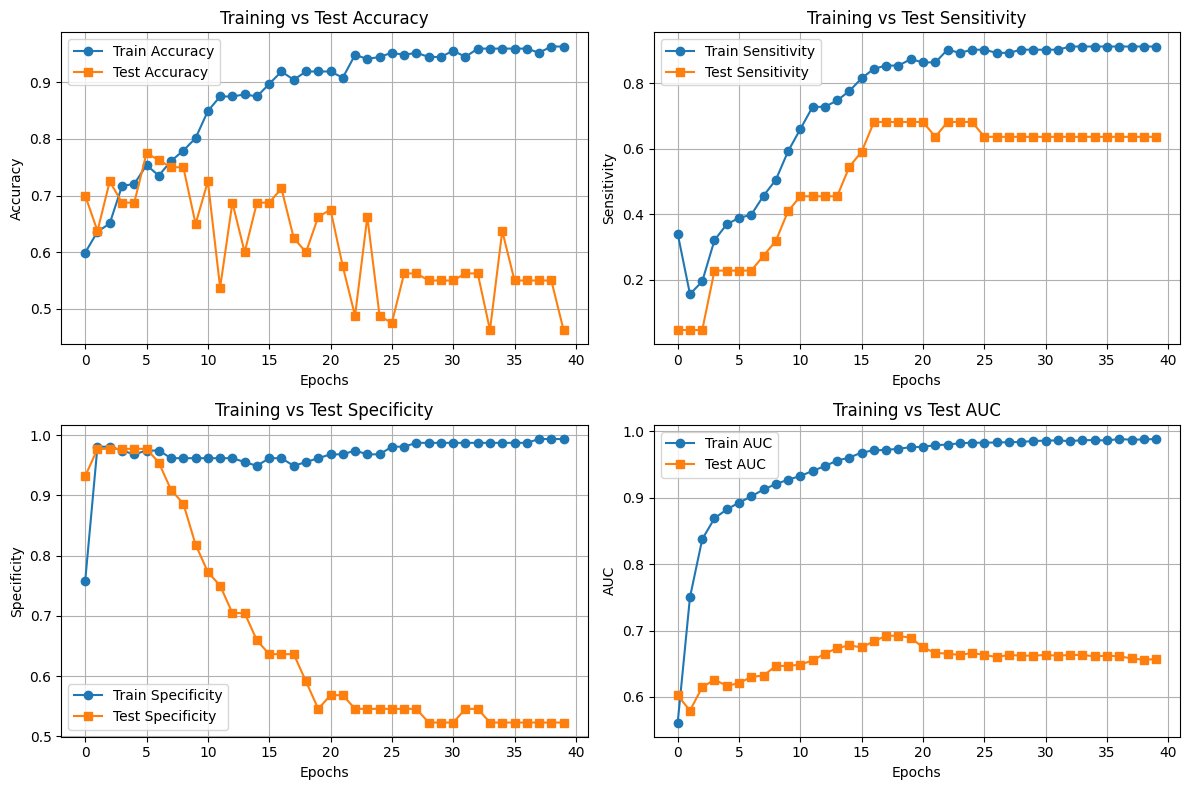

In [ ]:
plot_metrics_from_tensorboard(writer.get_logdir())

In [ ]:
def add_variable_gaussian_noise(data, mean=0.0, base_std=0.01, std_variation=0.005):
    """
    Adds Gaussian noise with a variable standard deviation across the sequence length.

    Parameters:
        data (torch.Tensor): Input tensor of shape (batch, channels, seq_length)
        mean (float): Mean of Gaussian noise
        base_std (float): Base standard deviation for the noise
        std_variation (float): How much std can vary across the sequence

    Returns:
        torch.Tensor: Noisy data
    """
    batch, channels, seq_length = data.shape

    # Generate random std values per sequence position (smooth transitions)
    std_values = base_std + torch.rand(batch, channels, seq_length) * std_variation

    # Generate Gaussian noise with varying std
    noise = torch.randn_like(data) * std_values + mean
    return data + noise

In [ ]:
class AugmentedFHRDataset(Dataset):
    def __init__(self, original_dataset, augment_factor=2,std=0.05):
        self.original_dataset = original_dataset
        self.augment_factor = augment_factor
        self.std = std

    def __len__(self):
        return len(self.original_dataset) * self.augment_factor  # Triples dataset size

    def __getitem__(self, idx):
        original_idx = idx // self.augment_factor  # Map back to original index
        x, y = self.original_dataset[original_idx]

        # Apply noise to training samples only
        x_augmented = add_gaussian_noise(x,std=self.std) # Apply augmentation to x

        return x_augmented, y # Return augmented x and original y

In [ ]:
# Dataset and DataLoader
labels_2m_gaps_tensor = torch.tensor(labels_2m_gaps["label"].values, dtype=torch.float32)
dataset = FHRDataset(t_lasthour_no2m_gaps_linearinterp_mean1hz_normalized, labels_2m_gaps_tensor)

# Split dataset into train and test
train_size = int(0.8 * len(dataset))  # 80% train, 20% test
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

augmented_train_dataset = AugmentedFHRDataset(train_dataset)

# Create DataLoaders
train_loader = DataLoader(augmented_train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize model, with dropout
model = MambaBinaryClassifier(d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand, dropout_rate=0.5, linear_input_dim = 3600).to(device)

# Load pre-trained weights for 'mamba' module
mamba_pretrained = MambaNextToken()
mamba_pretrained.load_state_dict(torch.load("/content/mamba_pretrained_t_lasthour_no2m_gaps_linearinterp_mean1hz.pth"))

pretrained_state_dict = mamba_pretrained.mamba.state_dict()
modified_state_dict = {k[6:]: v for k, v in pretrained_state_dict.items() if k.startswith('mamba.')}
model.mamba.load_state_dict(modified_state_dict, strict=False)

# Optimizer, loss, scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
criterion = nn.BCEWithLogitsLoss(pos_weight=weights[1]).to(device)
scheduler = StepLR(optimizer, step_size=scheduler_step_size, gamma=gamma)

writer = train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, scheduler)

Epoch 1: Train Loss: 0.9600, Train Acc: 0.5928 | Test Loss: 0.9648, Test Acc: 0.5500
Epoch 2: Train Loss: 0.9469, Train Acc: 0.6307 | Test Loss: 0.9694, Test Acc: 0.5500
Epoch 3: Train Loss: 0.9374, Train Acc: 0.6364 | Test Loss: 0.9717, Test Acc: 0.5500
Epoch 4: Train Loss: 0.9308, Train Acc: 0.6307 | Test Loss: 0.9747, Test Acc: 0.5500
Epoch 5: Train Loss: 0.9230, Train Acc: 0.6326 | Test Loss: 0.9754, Test Acc: 0.5500
Epoch 6: Train Loss: 0.9156, Train Acc: 0.6458 | Test Loss: 0.9740, Test Acc: 0.5375
Epoch 7: Train Loss: 0.9054, Train Acc: 0.6875 | Test Loss: 0.9744, Test Acc: 0.5625
Epoch 8: Train Loss: 0.8909, Train Acc: 0.7216 | Test Loss: 0.9740, Test Acc: 0.4875
Epoch 9: Train Loss: 0.8742, Train Acc: 0.7765 | Test Loss: 0.9727, Test Acc: 0.5000
Epoch 10: Train Loss: 0.8580, Train Acc: 0.8125 | Test Loss: 0.9707, Test Acc: 0.5000
Epoch 11: Train Loss: 0.8396, Train Acc: 0.8409 | Test Loss: 0.9676, Test Acc: 0.5875
Epoch 12: Train Loss: 0.8242, Train Acc: 0.8390 | Test Loss: 0.

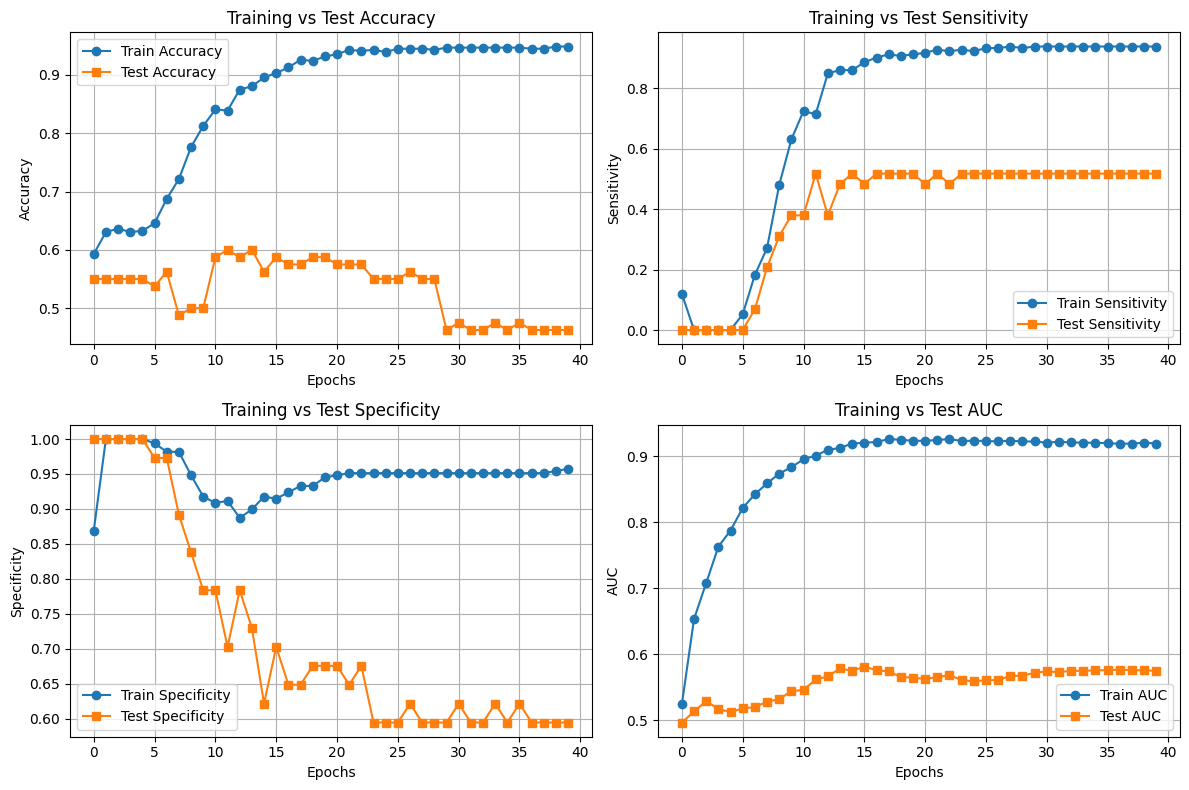

In [ ]:
plot_metrics_from_tensorboard(writer.get_logdir())